# CNN Building Process
    
    基于TensorFlow构建指定的网络结构
    这里使用卷积神经网络，是为了综合上下文信息，给出一句话中每个单词（token）对应的标签（tags）概率分布。使用CNN分析单词附近的文本,将在顶部使用密集层进行标签分类

## 预备知识
    
    1.环境：Tensorflow-gpu 的安装、配置（cuda，cudnn）以及使用，unfinished
    2.深度学习、CNN相关知识，嫉妒欠缺！！！
    3.Dataset的准备（之前所做）

In [2]:
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.set_random_seed(42)

/home/zhl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/zhl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


    几乎所有的自然语言处理网络结构都拥有一个必不可少的部分——单词嵌入。我们将文本分解为一系列tokens传入网络当中，每一个token又由他们的数字索引进行表示。每一个token（索引），都拥有一个向量，所有的向量形成嵌入矩阵（embedding matrix）。该矩阵可以使用一些常用算法（如Skip-Gram或CBOW）进行预训练，也可以通过随机值进行初始化，并与网络的其他参数一起进行训练。 在本教程中，我们将遵循第二种选择。
    
    我们下面需要构建一个函数，其采用[batch_size, num_tokens]形状的标记索引的张量，并且对于这个矩阵中的每个索引，它从嵌入矩阵中检索对应于该索引的张量。这会产生一个新的张量，形状为[batch_size,num_tokens,emb_dim]。

In [3]:
def get_embeddings(indices, vocabulary_size, emb_dim):
    # Initialize the random gaussian matrix with dimensions [vocabulary_size, embedding_dimension]
    # np.random.randn()初始化一个矩阵，形状为[vocabulary_size, embedding_dimension]，内部元素服从标准高斯分布，类型为np.float32
    # The **VARIANCE** of the random samples must be 1 / embedding_dimension
    # 随机样本的方差是 1/embedding_dimension??
    #np.random.randn()返回一组符合指定维度的样本方差为1(标准正态分布),这里是词嵌入矩阵,列数代表词向量的维度,行数代表词的个数,输入的独热向量代表id,根据词的下标选择矩阵中对应行,对应一个词向量,获得的方差为1/emb_dim
    emb_mat = np.random.randn(vocabulary_size, emb_dim).astype(np.float32) / np.sqrt(emb_dim) 
    
    # 构造一个能用Tensorflow计算的变量 ↓
    # 参考 http://www.cnblogs.com/nowornever-L/p/6908775.html
    emb_mat = tf.Variable(emb_mat, name='Embeddings', trainable=True)
    
    # 在emb_mat中检索indices所表示的内容
    emb = tf.nn.embedding_lookup(emb_mat, indices)
    return emb

    神经网络的主体是卷积层(convolutional layers)，即对每n个连续tokens，应用相同的全连接层(dense layer)。
    
    致密层是指每个神经元从前一层的所有神经元获得输入进而实现密集连接。层应该拥有一个权重矩阵 W 和一个偏差矩阵 b。
    致密层就像是实现了矩阵的乘法。
    
    简化情况如下。

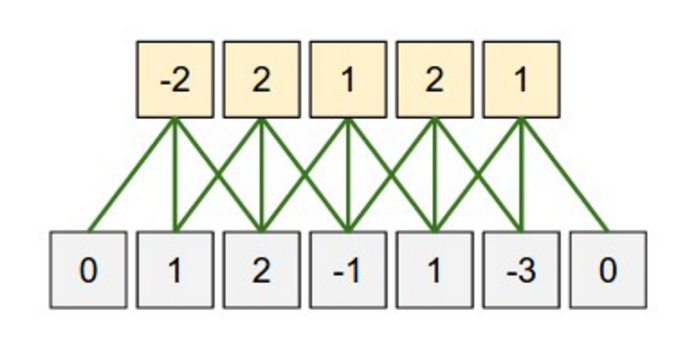


In [32]:
import tensorflow as tf

# Create a tensor with shape [batch_size, number_of_tokens, number_of_features]
x = tf.random_normal(shape=[2, 10, 100]) # 输入矩阵，由服从标准正态分布的数值填充.矩阵的长为2,宽为10,每一个元素为长度为100的词向量
#这里的长为之前处理的每次选取的句子数目,宽为每一个句子最长的单词数,假定10

# 生成卷积核，filter对应的是卷积核的数目和输出的矩阵的维度.kernel对应的是卷积核的长度(默认宽度为1),默认步长为1
#卷积核与输入矩阵进行卷积运算,得到一个长度为3(10-8+1),宽度为2的特征矩阵,矩阵的每一个元素为一个特征值(注意:卷积核的每一个元素也是长度为100的
#向量,卷积运算后每一个矩阵元素为一个数值)
#对于200个卷积核,产生200个这样的矩阵,200个特征元素对应合并,产生输出
y = tf.layers.conv1d(x, filters=200, kernel_size=8)
print(y) # Tensor("conv1d/BiasAdd:0", shape=(2, 3, 200), dtype=float32)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(y))
#print(sess.run(x))

# 没有用0在输入的开头和结尾进行填充，导致token的维度降低
y_with_padding = tf.layers.conv1d(x, filters=200, kernel_size=8, padding='same')
#print(y_with_padding)
init = tf.global_variables_initializer()
sess.run(init)
#print(sess.run(y_with_padding))

# 堆放一些致密层
def conv_net(units, n_hidden_list, cnn_filter_width, activation=tf.nn.relu):
    
    for n_hidden in n_hidden_list:
        units = tf.layers.conv1d(units,
                                 n_hidden,
                                 cnn_filter_width,
                                 padding='same')
        units = activation(units) # Use activation(units) to apply activation to units
    return units

Tensor("conv1d_49/BiasAdd:0", shape=(2, 1, 200), dtype=float32)
[[[-2.42348090e-02  3.93365175e-02 -1.93232954e-01 -1.39818251e-01
    1.47422310e-03 -1.85986787e-01 -2.07810581e-01 -1.44550428e-02
   -1.78892702e-01  1.49174049e-01 -4.09731597e-01 -3.49793918e-02
   -2.84604013e-01  2.88720489e-01  2.57493019e-01 -5.49692333e-01
    3.22259992e-01 -8.96736383e-02 -2.07219273e-03 -1.66132510e-01
    2.06664935e-01 -3.23227011e-02 -1.80382431e-01  4.25300375e-02
   -1.64515793e-01 -3.97597030e-02  3.09976071e-01  3.43446195e-01
    6.98813573e-02 -2.23558038e-01 -2.97509879e-01 -9.38725844e-02
    5.37956879e-02 -5.79953790e-02  3.53172183e-01 -1.90704018e-01
    7.76588917e-03  4.03384298e-01  7.18946457e-02 -1.45447642e-01
   -7.86067605e-01 -1.80495858e-01  2.93439090e-01 -2.54239172e-01
    2.82373905e-01 -1.80475280e-01  8.67078453e-02 -5.54156713e-02
    2.00152606e-01  1.30314067e-01  2.28183307e-02 -1.29942194e-01
    1.61527798e-01 -1.67402223e-01 -2.38198876e-01  5.25373816e-0

    实现分类工作的一个常用损失函数是‘交叉熵’。为什么要分类呢？因为对于每个token，神经网络必须决定到底如何预测它的tag。
    交叉熵函数格式如下：

$$ H(P, Q) = -E_{x \sim P} log Q(x) $$

交叉熵衡量了真实分布与预测分布之间的差异。而通常真实分布是独热向量。交叉熵损失函数已经 [集成](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2) 在TensorFlow中了。

In [8]:
# The logits分类评定模型
# shape [batch_size, number_of_tokens, number of classes]
l = tf.random_normal([1, 4, 3])
# TensorFlow的占位符，此函数可以理解为形参，用于定义过程，在执行的时候再赋具体的值
indices = tf.placeholder(tf.int32, [1, 4])

# Make one-hot distribution from indices for 3 types of tag
# 根据indices的值，返回若干个矩阵，矩阵中有若干个独热向量，每个向量对应一个token，反映其tag
# 参考 https://www.w3cschool.cn/tensorflow_python/tensorflow_python-fh1b2fsm.html
p = tf.one_hot(indices, depth=3)

# 计算 logits 与 labels 的 softmax 交叉熵
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=p, logits=l)
print(loss_tensor)

AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'softmax_cross_entropy_with_logits_v2'

    我们把每一个句子的长度变为最长的那一个后，每一批样本的所有句子都是一样长的。所以句子的末尾常常有填充的内容，而令神经网络去预测这些填充内容常常会使预测质量下降。所以我们需要用之前的二进制表示的面具（Mask）向量乘以损失向量，来防止梯度沿填充内容下降。

In [ ]:
mask = tf.placeholder(tf.float32, shape=[1, 4])
loss_tensor *= mask

    现在定义返回去除填充部分的损失函数：

In [ ]:
def masked_cross_entropy(logits, label_indices, number_of_tags, mask):
    ground_truth_labels = tf.one_hot(label_indices, depth=number_of_tags)
    loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ground_truth_labels, logits=logits)
    loss_tensor *= mask
    
    # 最后一步是计算损失向量的均值
    loss = tf.reduce_mean(loss_tensor)
    return loss

    以上所有的步骤封装成 NerNetwork类：

In [ ]:
import numpy as np
import tensorflow as tf

class NerNetwork:
    def __init__(self,
                 n_tokens,
                 n_tags,
                 token_emb_dim=100,
                 n_hidden_list=(128,),
                 cnn_filter_width=7,
                 use_batch_norm=False,
                 embeddings_dropout=False,
                 top_dropout=False,
                 **kwargs):
        
        # ================ Building inputs =================
        
        self.learning_rate_ph = tf.placeholder(tf.float32, [])
        self.dropout_keep_ph = tf.placeholder(tf.float32, [])
        self.token_ph = tf.placeholder(tf.int32, [None, None], name='token_ind_ph')
        self.mask_ph = tf.placeholder(tf.float32, [None, None], name='Mask_ph')
        self.y_ph = tf.placeholder(tf.int32, [None, None], name='y_ph')
        
        # ================== Building the network ==================
        
        # Now embedd the indices of tokens using token_emb_dim function
        
        def get_embeddings(indices, vocabulary_size, emb_dim):
            emb_mat = np.random.randn(vocabulary_size, emb_dim).astype(np.float32) / np.sqrt(emb_dim) # YOUR CODE HERE
            emb_mat = tf.Variable(emb_mat, name='Embeddings', trainable=True)
            emb = tf.nn.embedding_lookup(emb_mat, indices)
            return emb
        
        emb = get_embeddings(self.token_ph, n_tokens, token_emb_dim)
        

        emb = tf.nn.dropout(emb, self.dropout_keep_ph, (tf.shape(emb)[0], 1, tf.shape(emb)[2]))
        
        # Build a multilayer CNN on top of the embeddings.
        # The number of units in the each layer must match
        # corresponding number from n_hidden_list.
        # Use ReLU activation 
        
        def conv_net(units, n_hidden_list, cnn_filter_width, activation=tf.nn.relu):
            # Use activation(units) to apply activation to units
            for n_hidden in n_hidden_list:
                units = tf.layers.conv1d(units,
                                         n_hidden,
                                         cnn_filter_width,
                                         padding='same')
                units = activation(units)
            return units
        
        units = conv_net(emb, n_hidden_list, cnn_filter_width)
        
        units = tf.nn.dropout(units, self.dropout_keep_ph, (tf.shape(units)[0], 1, tf.shape(units)[2]))
        logits = tf.layers.dense(units, n_tags, activation=None)
        self.predictions = tf.argmax(logits, 2)
        
        # ================= Loss and train ops =================
        # Use cross-entropy loss. check the tf.nn.softmax_cross_entropy_with_logits_v2 function
        
        def masked_cross_entropy(logits, label_indices, number_of_tags, mask):
            ground_truth_labels = tf.one_hot(label_indices, depth=number_of_tags)
            loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=ground_truth_labels, logits=logits)
            loss_tensor *= mask
            loss = tf.reduce_mean(loss_tensor)
            return loss      
        
        self.loss = masked_cross_entropy(logits, self.y_ph, n_tags, self.mask_ph)

        # Create a training operation to update the network parameters.
        # We purpose to use the Adam optimizer as it work fine for the
        # most of the cases. Check tf.train to find an implementation.
        # Put the train operation to the attribute self.train_op
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate_ph)
        self.train_op = optimizer.minimize(self.loss)
        
        # ================= Initialize the session =================
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def __call__(self, tok_batch, mask_batch):
        feed_dict = {self.token_ph: tok_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: 1.0}
        return self.sess.run(self.predictions, feed_dict)

    def train_on_batch(self, tok_batch, tag_batch, mask_batch, dropout_keep_prob, learning_rate):
        feed_dict = {self.token_ph: tok_batch,
                     self.y_ph: tag_batch,
                     self.mask_ph: mask_batch,
                     self.dropout_keep_ph: dropout_keep_prob,
                     self.learning_rate_ph: learning_rate}
        self.sess.run(self.train_op, feed_dict)


In [ ]:
# 使用之前的token_vocab和tag_vocab，创建一个实例
nernet = NerNetwork(len(token_vocab),
                    len(tag_vocab),
                    n_hidden_list=[100, 100])